# Pysch 45: Emotional memory demo results

In [145]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

sns.set(style='ticks', font_scale=1.5)

In [146]:
df = pd.read_csv('HITResultsFor3UEDKCTP9VQSZE86QJFHRRFFFRL7KU.csv', index_col=False)

In [147]:
df.head()

,HitId,HitTitle,Annotation,AssignmentId,WorkerId,Status,AcceptTime,SubmitTime,Answer 1
0,3UEDKCTP9VQSZE86QJFHRRFFFRL7KU,P45: emotional memory demo,,3LWJHTCVCCMUBUJ1B92RZO0M486QFK,A7NX912ETMBWU,Approved,Tue May 03 14:33:13 PDT 2016,Tue May 03 14:33:34 PDT 2016,"{""trials"":[],""thisList"":[""torture"",""love"",""mir..."
1,3UEDKCTP9VQSZE86QJFHRRFFFRL7KU,P45: emotional memory demo,,30X31N5D63QBSJH6SX54GN4WPGUASW,A1XK2SQ0Z4SCPP,Approved,Tue May 10 16:17:13 PDT 2016,Tue May 10 16:21:09 PDT 2016,"{""trials"":[],""thisList"":[""slaughter"",""contents..."
2,3UEDKCTP9VQSZE86QJFHRRFFFRL7KU,P45: emotional memory demo,,3P529IW9KYLJKX3OJ4UVI21SU2ZFL0,A1JGUKICUQDH0L,Approved,Tue May 10 18:09:06 PDT 2016,Tue May 10 18:12:53 PDT 2016,"{""trials"":[],""thisList"":[""romantic"",""cash"",""gr..."
3,3UEDKCTP9VQSZE86QJFHRRFFFRL7KU,P45: emotional memory demo,,3TU5ZICBRD1LWF9E3VWLPWJ0H49Q8J,A3GNVSUHSIJEDW,Approved,Tue May 10 18:35:47 PDT 2016,Tue May 10 18:43:27 PDT 2016,"{""trials"":[],""thisList"":[""laughter"",""pecan"",""g..."
4,3UEDKCTP9VQSZE86QJFHRRFFFRL7KU,P45: emotional memory demo,,3QRYMNZ7FYHJR2OAQ1FZCYKIQ6ANTL,A2PHAETQOS0JPI,Approved,Thu May 12 11:11:18 PDT 2016,Thu May 12 11:16:34 PDT 2016,"{""trials"":[],""thisList"":[""slaughter"",""broom"",""..."


#### Number of participants

In [148]:
df.shape[0] - 1

16

## Pull out important data from Turk output

In [149]:
def add_null_col(df, col_names):
    for col in col_names:
        df[col] = np.nan
    return df

In [150]:
dtrials = pd.DataFrame()

condition_list = ['pos', 'neg', 'neut']
df = add_null_col(df, condition_list)

for sub in df.iterrows():
        
    index = sub[0]
    row = sub[1]
    
    # extract trial data
    trial_count = len(eval(df.ix[index]['Answer 1'])['thisList'])
    dsub = pd.DataFrame([eval(df.ix[index]['Answer 1'])['thisList'],
                         eval(df.ix[index]['Answer 1'])['theseResults']],
                         index=['word', 'retrieved']).T
    dsub.loc[:,'retrieved'] = dsub.retrieved.astype(int)
    dsub['subid'] = index
    dsub['serial_pos'] = np.arange(1,trial_count+1)
    dtrials = dtrials.append(dsub, ignore_index=True)
        
    for cond in ['pos', 'neg', 'neut']:
        
        df.ix[index, cond] = eval(row['Answer 1'])['num' + cond]        


In [151]:
data = pd.DataFrame(df.loc[:,['pos', 'neg', 'neut']].stack().reset_index())
data.rename(columns={'level_0': 'subid', 
                     'level_1': 'valence', 
                     0: 'count'}, inplace=True)
data['proportion'] = data['count'].apply(lambda x: x/15)
data.head()

,subid,valence,count,proportion
0,0,pos,1,0.066667
1,0,neg,1,0.066667
2,0,neut,2,0.133333
3,1,pos,5,0.333333
4,1,neg,5,0.333333


In [152]:
data = data.loc[data.subid != 0] #remove "pilot" data
dtrials = dtrials.loc[dtrials.subid != 0].reset_index() #remove "pilot" data

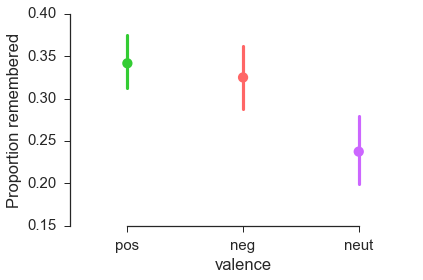

In [175]:
p = sns.factorplot(x='valence', y='proportion', 
                   hue='valence', units='subid', ci=68,
                   data=data, aspect=1.5,
                   palette=['#33cc33', '#ff6666', '#cc66ff'])

p.set_ylabels('Proportion remembered')
sns.despine(trim=True)

## Most commonly retrieved words

In [171]:
top_words = dtrials.groupby(['word']).sum().reset_index().sort('retrieved', 
                                                               ascending=False)
top_words['P(retrieved)'] = top_words.retrieved.apply(lambda x: float(x)/len(dtrials.subid.unique()))

top_words.loc[top_words['P(retrieved)'] > .4,['word', 'P(retrieved)']]

,word,P(retrieved)
32,rape,0.7500
22,love,0.6875
24,mother,0.5625
39,suicide,0.5000
17,kiss,0.5000
40,sweetheart,0.4375
8,depression,0.4375
19,laughter,0.4375
31,rainbow,0.4375
9,duct,0.4375


## Serial position effect

In [156]:
dtrials.index = dtrials.serial_pos

### Smoothed serial position

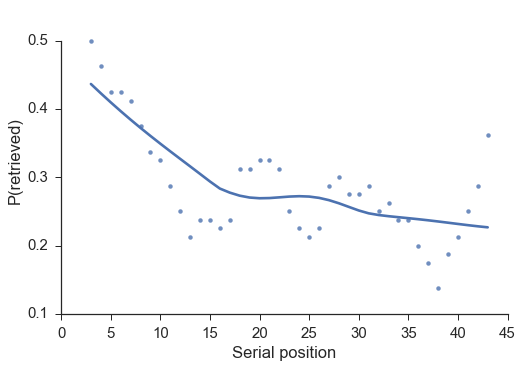

In [181]:
smoothing_factor = 5

dserial = dtrials
dserial = dserial.groupby(['serial_pos']).sum().reset_index()
dserial = pd.rolling_mean(dserial.loc[:,['serial_pos', 'retrieved']], smoothing_factor, center=False)
dserial['P(retrieved)'] = dserial.retrieved.apply(lambda x: float(x)/len(dtrials.subid.unique()))

p = sns.regplot(x='serial_pos', y='P(retrieved)', 
                lowess=True,
                data=dserial)

plt.locator_params(axis='x',nbins=15)
plt.xlim(0,dtrials.serial_pos.max())
plt.xlabel('Serial position')

sns.despine(trim=True)

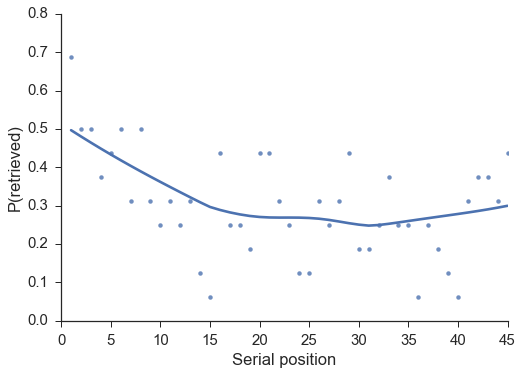

In [182]:
dserial = dtrials.groupby(['serial_pos']).sum().reset_index()
dserial['P(retrieved)'] = dserial.retrieved.apply(lambda x: float(x)/len(dtrials.subid.unique()))

p = sns.regplot(x='serial_pos', y='P(retrieved)', 
                lowess=True,
                data=dserial)

plt.locator_params(axis='x',nbins=15)
plt.xlim(0,dtrials.serial_pos.max())
plt.xlabel('Serial position')

sns.despine(trim=True)